# Embedding-Based Zero-Shot Classification

**Approach**: Semantic similarity using sentence embeddings

This approach improves upon rule-based matching by:
1. Embedding job titles using sentence-transformers (multilingual model)
2. Finding K-nearest neighbors in embedding space
3. Assigning labels via majority vote or weighted similarity

**Advantages over rule-based**:
- Captures semantic meaning (e.g., "Developer" ≈ "Engineer")
- Handles multilingual data (German/French/English)
- Better generalization to unseen job titles

**Training Data**: Lookup tables (~19k examples) embedded as reference library  
**Validation Data**: Annotated LinkedIn CVs (loaded only for evaluation)

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Import data loaders and models
import sys
sys.path.append('../')
from src.data.loader import load_label_lists, load_inference_dataset, load_evaluation_dataset
from src.models.embedding_classifier import EmbeddingClassifier, create_domain_classifier, create_seniority_classifier

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
RESULTS_DIR.mkdir(exist_ok=True)

%matplotlib inline

## 1. Load Training Data (Lookup Tables)

In [2]:
# Load lookup tables
dept_df, sen_df = load_label_lists(DATA_DIR)

print(f"Department lookup: {len(dept_df):,} examples")
print(f"Seniority lookup:  {len(sen_df):,} examples")
print(f"\nUnique departments: {dept_df['label'].nunique()}")
print(f"Unique seniority levels: {sen_df['label'].nunique()}")

Department lookup: 10,145 examples
Seniority lookup:  9,428 examples

Unique departments: 11
Unique seniority levels: 5


## 2. Build Embedding Classifiers

We'll use **multilingual sentence-transformers** to handle German/French/English data.

Model: `paraphrase-multilingual-MiniLM-L12-v2`
- Fast and efficient (12 layers)
- Supports 50+ languages
- Good quality embeddings for semantic search

In [3]:
# Create embedding classifiers using factory functions
# These will embed all lookup table examples and average them per label (centroid approach)

print("Creating department classifier...")
start_time = time.time()
dept_clf = create_domain_classifier(
    dept_df, 
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_examples=True  # Use averaged example embeddings (more robust)
)
dept_time = time.time() - start_time
print(f"✅ Department classifier created in {dept_time:.1f}s")

print("\nCreating seniority classifier...")
start_time = time.time()
sen_clf = create_seniority_classifier(
    sen_df,
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_examples=True
)
sen_time = time.time() - start_time
print(f"✅ Seniority classifier created in {sen_time:.1f}s")

print(f"\nTotal embedding time: {dept_time + sen_time:.1f}s")

Creating department classifier...
Loading model 'paraphrase-multilingual-MiniLM-L12-v2' on cuda...
Model loaded successfully!
Fitted from examples: 11 labels, shape (11, 384)
✅ Department classifier created in 20.2s

Creating seniority classifier...
Loading model 'paraphrase-multilingual-MiniLM-L12-v2' on cuda...
Model loaded successfully!
Fitted from examples: 5 labels, shape (5, 384)
✅ Seniority classifier created in 3.9s

Total embedding time: 24.1s


## 3. Inference Demo on Unannotated CVs

In [4]:
# Load unannotated CVs for demonstration
inference_df = load_inference_dataset(DATA_DIR)

print(f"Loaded {len(inference_df):,} unannotated CV positions for inference demo")
print(f"\nFirst few job titles:")
for i, row in inference_df.head(10).iterrows():
    print(f"  {i+1}. {row['title']}")

Loaded 314 unannotated CV positions for inference demo

First few job titles:
  1. Bookkeeper
  2. Strategy & Investments
  3. Corporate Auditor
  4. Marketing Manager
  5. Professor
  6. Program Purchasing Leader / Program / Acquisition Buyer
  7. Business Analyst
  8. Managementberater IT- und Governance
  9. Founder & CEO
  10. Geschäftsführer


In [5]:
# Make predictions on sample with confidence scores
sample_titles = inference_df['title'].head(20).tolist()

# Predict with confidence
dept_preds = dept_clf.predict_with_confidence(sample_titles)
sen_preds = sen_clf.predict_with_confidence(sample_titles)

# Display results
print("\n" + "="*110)
print("INFERENCE DEMO: Embedding-Based Predictions")
print("="*110)
print(f"{'Title':<40} | {'Department':<20} | {'Conf':<6} | {'Seniority':<15} | {'Conf':<6}")
print("-"*110)

for title, (dept, dept_conf), (sen, sen_conf) in zip(sample_titles, dept_preds, sen_preds):
    title_short = title[:37] + "..." if len(title) > 40 else title
    print(f"{title_short:<40} | {dept:<20} | {dept_conf:<6.3f} | {sen:<15} | {sen_conf:<6.3f}")


INFERENCE DEMO: Embedding-Based Predictions
Title                                    | Department           | Conf   | Seniority       | Conf  
--------------------------------------------------------------------------------------------------------------
Bookkeeper                               | Consulting           | 0.516  | Junior          | 0.512 
Strategy & Investments                   | Project Management   | 0.570  | Senior          | 0.501 
Corporate Auditor                        | Sales                | 0.549  | Management      | 0.570 
Marketing Manager                        | Marketing            | 0.769  | Director        | 0.723 
Professor                                | Administrative       | 0.504  | Junior          | 0.526 
Program Purchasing Leader / Program /... | Purchasing           | 0.686  | Director        | 0.679 
Business Analyst                         | Business Development | 0.815  | Junior          | 0.752 
Managementberater IT- und Governance     | O

## 4. Top-K Predictions Analysis

Let's examine the top-3 predictions for each title to understand model confidence.

In [6]:
# Get top-3 predictions for a few examples
sample_top_k = dept_clf.predict_top_k(sample_titles[:5], k=3)

print("Top-3 Department Predictions (with similarity scores):\n")
for title, top_k in zip(sample_titles[:5], sample_top_k):
    print(f"\n📌 {title}")
    for rank, (label, score) in enumerate(top_k, 1):
        print(f"   {rank}. {label:<30} (similarity: {score:.4f})")

Top-3 Department Predictions (with similarity scores):


📌 Bookkeeper
   1. Consulting                     (similarity: 0.5160)
   2. Administrative                 (similarity: 0.5067)
   3. Information Technology         (similarity: 0.4636)

📌 Strategy & Investments
   1. Project Management             (similarity: 0.5704)
   2. Business Development           (similarity: 0.5046)
   3. Consulting                     (similarity: 0.4701)

📌 Corporate Auditor
   1. Sales                          (similarity: 0.5488)
   2. Administrative                 (similarity: 0.5433)
   3. Business Development           (similarity: 0.5163)

📌 Marketing Manager
   1. Marketing                      (similarity: 0.7693)
   2. Other                          (similarity: 0.7194)
   3. Sales                          (similarity: 0.6861)

📌 Professor
   1. Administrative                 (similarity: 0.5040)
   2. Consulting                     (similarity: 0.4666)
   3. Information Technology         

## 5. Confidence Distribution Analysis

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

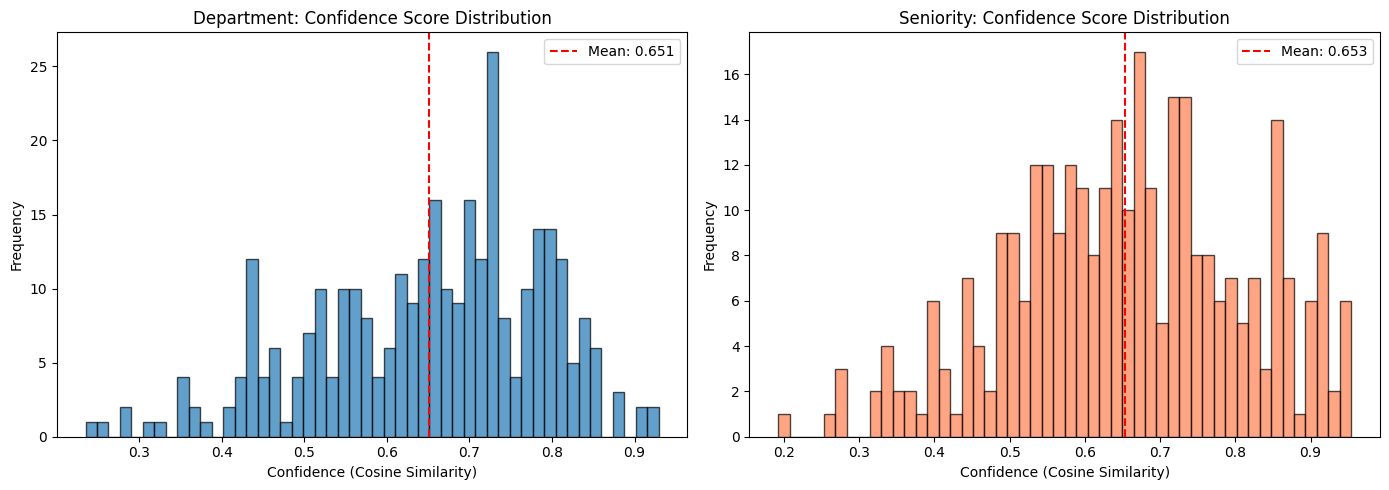


Department confidence - Mean: 0.6512, Median: 0.6703
Seniority confidence  - Mean: 0.6533, Median: 0.6539


In [7]:
# Analyze confidence scores on all inference data
all_titles = inference_df['title'].tolist()
all_dept_preds = dept_clf.predict_with_confidence(all_titles)
all_sen_preds = sen_clf.predict_with_confidence(all_titles)

dept_confidences = [conf for _, conf in all_dept_preds]
sen_confidences = [conf for _, conf in all_sen_preds]

# Visualize confidence distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(dept_confidences, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(dept_confidences), color='red', linestyle='--', 
                label=f'Mean: {np.mean(dept_confidences):.3f}')
axes[0].set_title('Department: Confidence Score Distribution', fontsize=12)
axes[0].set_xlabel('Confidence (Cosine Similarity)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].hist(sen_confidences, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(np.mean(sen_confidences), color='red', linestyle='--',
                label=f'Mean: {np.mean(sen_confidences):.3f}')
axes[1].set_title('Seniority: Confidence Score Distribution', fontsize=12)
axes[1].set_xlabel('Confidence (Cosine Similarity)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nDepartment confidence - Mean: {np.mean(dept_confidences):.4f}, Median: {np.median(dept_confidences):.4f}")
print(f"Seniority confidence  - Mean: {np.mean(sen_confidences):.4f}, Median: {np.median(sen_confidences):.4f}")

## 6. Evaluation on Annotated Dataset

⚠️ **LOADING ANNOTATED DATA FOR EVALUATION**

In [8]:
# Load annotated dataset for evaluation
eval_df = load_evaluation_dataset(DATA_DIR)

print(f"📊 Loaded {len(eval_df)} annotated CV positions for evaluation")
print(f"\nColumns: {list(eval_df.columns)}")

📊 Loaded 478 annotated CV positions for evaluation

Columns: ['cv_id', 'title', 'company', 'text', 'department', 'seniority']


### 6.1 Department Evaluation

In [9]:
# Predict on evaluation set
eval_titles = eval_df['title'].tolist()
dept_predictions = dept_clf.predict(eval_titles)

# Ground truth
dept_true = eval_df['department'].tolist()

# Calculate metrics
dept_accuracy = accuracy_score(dept_true, dept_predictions)
dept_precision, dept_recall, dept_f1, _ = precision_recall_fscore_support(
    dept_true, dept_predictions, average='macro', zero_division=0
)
dept_weighted_f1 = precision_recall_fscore_support(
    dept_true, dept_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("DEPARTMENT CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:          {dept_accuracy:.4f}")
print(f"Precision (macro): {dept_precision:.4f}")
print(f"Recall (macro):    {dept_recall:.4f}")
print(f"F1-score (macro):  {dept_f1:.4f}")
print(f"F1-score (wtd):    {dept_weighted_f1:.4f}")
print("="*60)

Batches:   0%|          | 0/15 [00:00<?, ?it/s]


DEPARTMENT CLASSIFICATION RESULTS
Accuracy:          0.4038
Precision (macro): 0.3789
Recall (macro):    0.4568
F1-score (macro):  0.3643
F1-score (wtd):    0.4382


In [10]:
# Per-class F1 scores
dept_report = classification_report(dept_true, dept_predictions, output_dict=True, zero_division=0)

print("\nPer-Class F1 Scores (Department):")
dept_f1_scores = {label: metrics['f1-score'] for label, metrics in dept_report.items() 
                  if label not in ['accuracy', 'macro avg', 'weighted avg']}
for label, f1 in sorted(dept_f1_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {label:<30}: {f1:.4f}")


Per-Class F1 Scores (Department):
  Human Resources               : 0.5128
  Other                         : 0.4868
  Project Management            : 0.4651
  Sales                         : 0.4444
  Purchasing                    : 0.4211
  Consulting                    : 0.4048
  Marketing                     : 0.3846
  Information Technology        : 0.3636
  Business Development          : 0.2222
  Customer Support              : 0.2000
  Administrative                : 0.1020


### 6.2 Seniority Evaluation

In [11]:
# Predict on evaluation set
sen_predictions = sen_clf.predict(eval_titles)

# Ground truth
sen_true = eval_df['seniority'].tolist()

# Calculate metrics
sen_accuracy = accuracy_score(sen_true, sen_predictions)
sen_precision, sen_recall, sen_f1, _ = precision_recall_fscore_support(
    sen_true, sen_predictions, average='macro', zero_division=0
)
sen_weighted_f1 = precision_recall_fscore_support(
    sen_true, sen_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("SENIORITY CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:          {sen_accuracy:.4f}")
print(f"Precision (macro): {sen_precision:.4f}")
print(f"Recall (macro):    {sen_recall:.4f}")
print(f"F1-score (macro):  {sen_f1:.4f}")
print(f"F1-score (wtd):    {sen_weighted_f1:.4f}")
print("="*60)

Batches:   0%|          | 0/15 [00:00<?, ?it/s]


SENIORITY CLASSIFICATION RESULTS
Accuracy:          0.3159
Precision (macro): 0.2327
Recall (macro):    0.4102
F1-score (macro):  0.2559
F1-score (wtd):    0.2767


In [12]:
# Per-class F1 scores
sen_report = classification_report(sen_true, sen_predictions, output_dict=True, zero_division=0)

print("\nPer-Class F1 Scores (Seniority):")
sen_f1_scores = {label: metrics['f1-score'] for label, metrics in sen_report.items() 
                 if label not in ['accuracy', 'macro avg', 'weighted avg']}
for label, f1 in sorted(sen_f1_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {label:<30}: {f1:.4f}")


Per-Class F1 Scores (Seniority):
  Management                    : 0.5860
  Director                      : 0.4615
  Lead                          : 0.3593
  Junior                        : 0.1069
  Senior                        : 0.0217
  Professional                  : 0.0000


## 7. Confusion Matrices

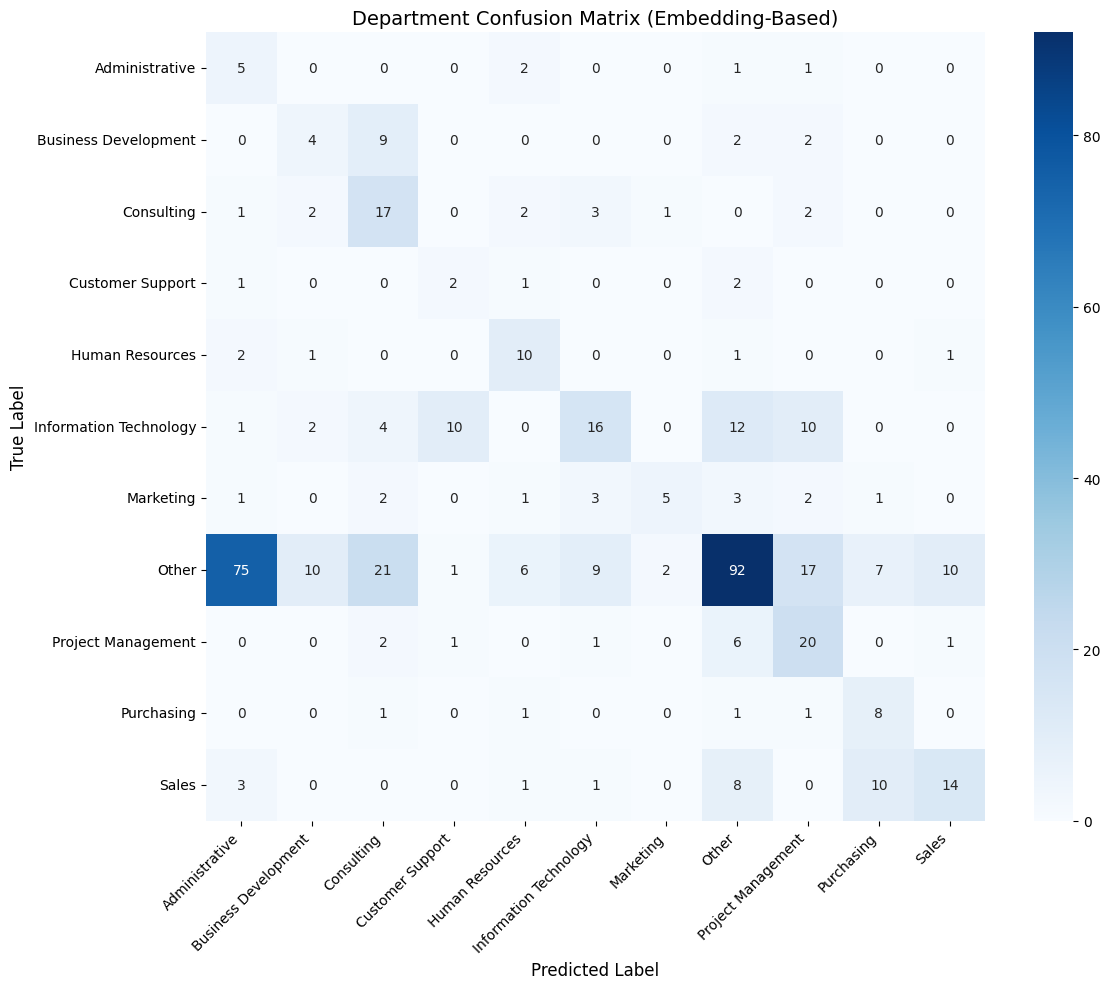

In [13]:
# Department confusion matrix
dept_cm = confusion_matrix(dept_true, dept_predictions)
dept_labels = sorted(set(dept_true + dept_predictions))

plt.figure(figsize=(12, 10))
sns.heatmap(dept_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels, yticklabels=dept_labels)
plt.title('Department Confusion Matrix (Embedding-Based)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

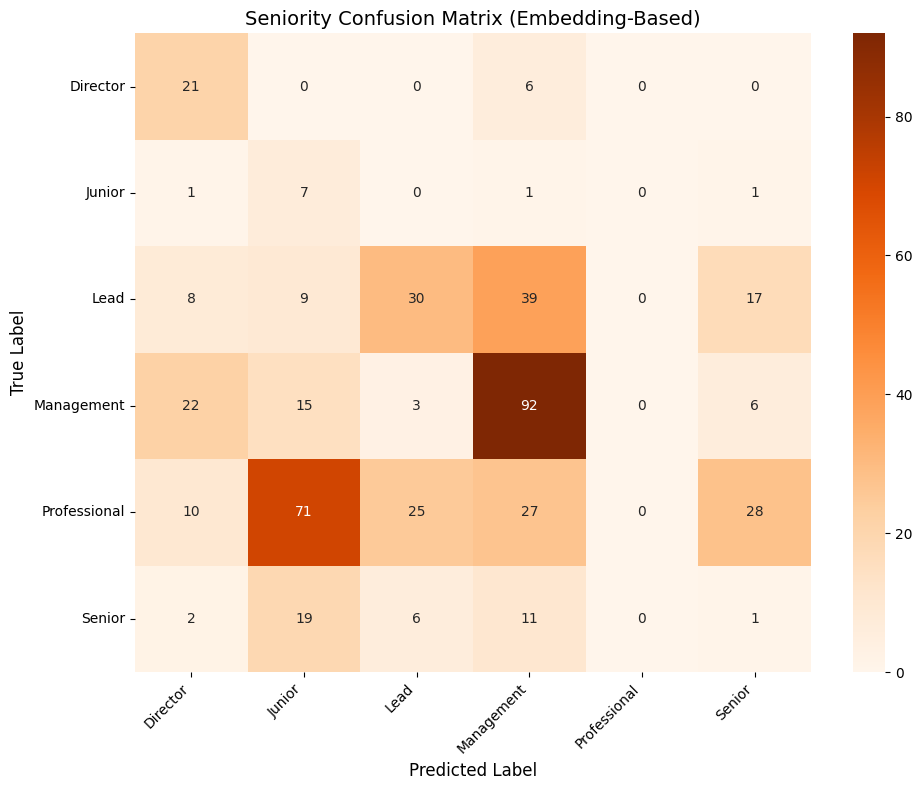

In [14]:
# Seniority confusion matrix
sen_cm = confusion_matrix(sen_true, sen_predictions)
sen_labels = sorted(set(sen_true + sen_predictions))

plt.figure(figsize=(10, 8))
sns.heatmap(sen_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels, yticklabels=sen_labels)
plt.title('Seniority Confusion Matrix (Embedding-Based)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 8. Error Analysis with Confidence

In [15]:
# Get predictions with confidence for error analysis
eval_dept_preds_conf = dept_clf.predict_with_confidence(eval_titles)
eval_sen_preds_conf = sen_clf.predict_with_confidence(eval_titles)

eval_df['dept_pred'] = [pred for pred, _ in eval_dept_preds_conf]
eval_df['dept_conf'] = [conf for _, conf in eval_dept_preds_conf]
eval_df['sen_pred'] = [pred for pred, _ in eval_sen_preds_conf]
eval_df['sen_conf'] = [conf for _, conf in eval_sen_preds_conf]
eval_df['dept_correct'] = eval_df['department'] == eval_df['dept_pred']
eval_df['sen_correct'] = eval_df['seniority'] == eval_df['sen_pred']

# Department errors
dept_errors = eval_df[~eval_df['dept_correct']].sort_values('dept_conf', ascending=False)
print(f"\nDepartment errors: {len(dept_errors)} / {len(eval_df)} ({100*len(dept_errors)/len(eval_df):.1f}%)")
print("\nHigh-confidence errors (Department):")
for i, row in dept_errors.head(5).iterrows():
    print(f"\n  Title: {row['title']}")
    print(f"    True: {row['department']}")
    print(f"    Pred: {row['dept_pred']} (confidence: {row['dept_conf']:.3f})")

# Seniority errors
sen_errors = eval_df[~eval_df['sen_correct']].sort_values('sen_conf', ascending=False)
print(f"\n{'='*80}")
print(f"Seniority errors: {len(sen_errors)} / {len(eval_df)} ({100*len(sen_errors)/len(eval_df):.1f}%)")
print("\nHigh-confidence errors (Seniority):")
for i, row in sen_errors.head(5).iterrows():
    print(f"\n  Title: {row['title']}")
    print(f"    True: {row['seniority']}")
    print(f"    Pred: {row['sen_pred']} (confidence: {row['sen_conf']:.3f})")

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]


Department errors: 285 / 478 (59.6%)

High-confidence errors (Department):

  Title: Kaufmännischer Leiter
    True: Sales
    Pred: Purchasing (confidence: 0.897)

  Title: Referatsleiter
    True: Other
    Pred: Administrative (confidence: 0.876)

  Title: Personalleiter
    True: Human Resources
    Pred: Administrative (confidence: 0.860)

  Title: Director Commercial Operations
    True: Marketing
    Pred: Other (confidence: 0.855)

  Title: HR IT Consultant
    True: Consulting
    Pred: Human Resources (confidence: 0.851)

Seniority errors: 327 / 478 (68.4%)

High-confidence errors (Seniority):

  Title: Managing Director
    True: Management
    Pred: Director (confidence: 0.940)

  Title: Managing Director
    True: Management
    Pred: Director (confidence: 0.940)

  Title: Managing Director
    True: Management
    Pred: Director (confidence: 0.940)

  Title: Managing Director
    True: Management
    Pred: Director (confidence: 0.940)

  Title: Managing Director
    True

## 9. Save Results for Comparison

In [16]:
# Prepare results dictionary
results = {
    "approach": "Embedding-Based (Sentence Transformers)",
    "department": {
        "accuracy": float(dept_accuracy),
        "precision": float(dept_precision),
        "recall": float(dept_recall),
        "f1_macro": float(dept_f1),
        "f1_weighted": float(dept_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in dept_f1_scores.items()}
    },
    "seniority": {
        "accuracy": float(sen_accuracy),
        "precision": float(sen_precision),
        "recall": float(sen_recall),
        "f1_macro": float(sen_f1),
        "f1_weighted": float(sen_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in sen_f1_scores.items()}
    },
    "metadata": {
        "model_name": "paraphrase-multilingual-MiniLM-L12-v2",
        "training_samples": len(dept_df) + len(sen_df),
        "dept_training_samples": len(dept_df),
        "sen_training_samples": len(sen_df),
        "embedding_method": "averaged_examples",
        "mean_dept_confidence": float(np.mean(dept_confidences)),
        "mean_sen_confidence": float(np.mean(sen_confidences))
    },
    "timestamp": datetime.now().isoformat()
}

# Save to JSON
output_path = RESULTS_DIR / 'embedding_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {output_path}")
print(f"\nSummary:")
print(f"  Department - Accuracy: {dept_accuracy:.4f}, F1 (macro): {dept_f1:.4f}")
print(f"  Seniority  - Accuracy: {sen_accuracy:.4f}, F1 (macro): {sen_f1:.4f}")


✅ Results saved to: results\embedding_results.json

Summary:
  Department - Accuracy: 0.4038, F1 (macro): 0.3643
  Seniority  - Accuracy: 0.3159, F1 (macro): 0.2559


---

## Summary

### Strengths
- ✅ Captures semantic meaning ("Developer" ≈ "Software Engineer")
- ✅ Good generalization to unseen job titles
- ✅ Multilingual support (German/French/English)
- ✅ Confidence scores provide uncertainty estimates
- ✅ No training required (zero-shot)

### Limitations
- ❌ Slower than rule-based (requires embedding computation)
- ❌ Less interpretable than exact matching
- ❌ Requires GPU for fast inference (CPU is slow)
- ❌ Still relies on lookup table distribution

### Comparison with Rule-Based
Expected improvements:
- Better handling of synonyms and paraphrases
- More robust to typos and variations
- Higher recall (finds more matches)

### Next Steps
- **Notebook 04**: Transformer fine-tuning (learns patterns from lookup data)
- **Notebook 05**: TF-IDF + Logistic Regression (interpretable baseline)
- **Notebook 99**: Compare all approaches